In [1]:
import torch
import torch.nn as nn
from torchvision import transforms
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
device = 'mps' if torch.backends.mps.is_available() else 'cpu'
print(device)

mps


In [78]:
data1 = pd.read_csv('archive/dataset/dataset.csv')
data2 = pd.read_csv('archive/fashion-mnist_test.csv')
d = torch.tensor(data1.to_numpy(), device=device)

gen = torch.Generator(device=device)
gen.manual_seed(123)

In [46]:
data_transform = transforms.Compose([
    transforms.RandomAffine(degrees=10, scale=(0.98, 1)),
    #transforms.transforms.RandomPerspective(distortion_scale=0.1, p=0.5),
    ])

In [50]:
aug_ratio = 3
X = d

for a in range(aug_ratio):
    aug = data_transform(d.view(len(d),1,64,64))
    tmp = aug.view(len(d),64*64)
    X = torch.cat((X,tmp), dim=0)

In [48]:
categories = np.unique(Y)

# Step 3: Select a sample from each category
samples_per_category = 1
selected_samples = []

for category in categories:
    category_indices = np.where(Y == category)[0]
    selected_index = np.random.choice(category_indices, samples_per_category, replace=False)
    selected_samples.extend(selected_index)

# Step 4: Plot the samples
plt.figure(figsize=(10, 5))
for i, sample_index in enumerate(selected_samples):
    plt.subplot(1, 10, i + 1)
    plt.imshow(X.cpu()[sample_index].reshape(28, 28), cmap='gray')
    plt.title(f'Label: {int(Y[sample_index])}')
    plt.axis('off')

plt.tight_layout()
plt.show()

NameError: name 'Y' is not defined

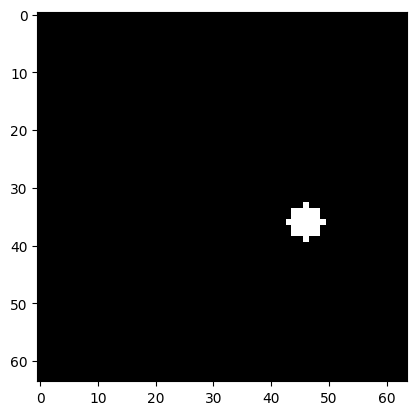

In [114]:
plt.imshow(d[torch.randint(0,len(X), (1,1))].to('cpu').view(64,64), cmap='gray')

In [51]:
Xn = X/255
Xn_test =  torch.tensor(data2.drop('label', axis = 1).to_numpy(), device=device) / 255

In [14]:
class CVAE(nn.Module):
    def __init__(self, lat):
        super().__init__()
        self.encoder = nn.Sequential( 
         nn.Conv2d(in_channels=1, out_channels=64, kernel_size=(5,5), padding=0), nn.MaxPool2d(2,2), nn.Dropout(0.1) , nn.LeakyReLU(),
         nn.Conv2d(in_channels=64, out_channels=16, kernel_size=(5,5), padding=0), nn.LeakyReLU(),
         nn.Flatten()
         )
        
        self.lat = lat
        self.z_mean = nn.Linear(8**2*16, self.lat)
        self.z_log_var = nn.Linear(8**2*16, self.lat)


        self.decoder = nn.Sequential(nn.Linear(lat,8**2*16), nn.Unflatten(1,(16,8,8)),
         nn.ConvTranspose2d(in_channels=16, out_channels=64, kernel_size=(5,5), padding=0) , nn.Upsample(scale_factor=2, mode='bilinear') , nn.Dropout(0.1), nn.LeakyReLU(),
         nn.ConvTranspose2d(in_channels=64, out_channels=1, kernel_size=(5,5), padding=0),  nn.LeakyReLU(),
        )
    

    def forward(self, i):
        
        x = self.encoder(i)
        mu = self.z_mean(x)
        log_sig = self.z_log_var(x)
        z = mu + torch.exp(log_sig/2) * torch.randn((1,self.lat), generator=gen, device=device)
        y = self.decoder(z)
                
        return i, y, mu, log_sig, self.lat
    
    @torch.no_grad()
    def generate(self):
        
        out = self.decoder(torch.randn((1,self.lat), device=device))
        return out
    
    @torch.no_grad()
    def decode(self,z):
        
        out = self.decoder(z)
        return out
    
    @torch.no_grad()
    def encode(self,i):
        
        x = self.encoder(i)
        mu = self.z_mean(x)
        log_sig = self.z_log_var(x)
        z = mu + torch.exp(log_sig/2) * torch.randn((1,self.lat), generator=gen, device=device)
        return z
    
    @torch.no_grad()
    def reproduce(self, i):
        
        x = self.encoder(i)
        mu = self.z_mean(x)
        log_sig = self.z_log_var(x)
        z = mu + torch.exp(log_sig/2) * torch.randn((1,self.lat), generator=gen, device=device)
        y = self.decoder(z)

        return y

In [15]:
class VAE(nn.Module):
    def __init__(self, lat):
        super().__init__()
        self.encoder = nn.Sequential( 
         nn.Linear(28*28,18*18), nn.LeakyReLU(),
         nn.Linear(18*18,8*8), nn.LeakyReLU(),
        # nn.Linear(12*12,8*8), nn.LeakyReLU(),
         )
        
        self.lat = lat
        self.z_mean = nn.Linear(8*8, self.lat)
        self.z_log_var = nn.Linear(8*8, self.lat)

        self.decoder = nn.Sequential(
         nn.Linear(self.lat,18*18), nn.LeakyReLU(),
        # nn.Linear(12*12,18*18),  nn.LeakyReLU(),
         nn.Linear(18*18,28*28),  nn.LeakyReLU(),
        )
    

    def forward(self, i):
        
        x = self.encoder(i)
        mu = self.z_mean(x)
        log_sig = self.z_log_var(x)
        z = mu + torch.exp(log_sig/2) * torch.randn((1,self.lat), generator=gen)
        y = self.decoder(z)
        
        return i, y, mu, log_sig
    
    @torch.no_grad()
    def generate(self):
        
        out = self.decoder(torch.randn((1,self.lat)))
        return out
    
    @torch.no_grad()
    def decode(self,z):
        
        out = self.decoder(z)
        return out
    
    @torch.no_grad()
    def reproduce(self, i):
        
        x = self.encoder(i)
        mu = self.z_mean(x)
        log_sig = self.z_log_var(x)
        z = mu + torch.exp(log_sig/2) * torch.randn((1,self.lat), generator=gen)
        y = self.decoder(z)

        return y

In [27]:
vae = CVAE(10).to(device)

In [28]:
def Loss(x,y,mu,log_sig, beta):

    l = torch.sum(torch.abs(x.view(-1,28*28)-y.view(-1,28*28)))
    #l = nn.functional.binary_cross_entropy(x,y) 
    kl = torch.mean(-0.5*torch.sum(1 + log_sig - mu*mu - torch.exp(log_sig), dim=1), dim=0)
    
    loss = l + beta*kl

    return loss 

optimizer = torch.optim.Adam(vae.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1, end_factor=0.3, total_iters=len(Xn))

print('The model has', sum(p.numel() for p in vae.parameters() if p.requires_grad), 'trainable parameters' )

The model has 86309 trainable parameters


In [29]:
batch = 128
loss_eval = 500
tot_epochs = 3
beta = 250

for epoch in range(tot_epochs):

    running_loss = 0.0
    for i in range(len(Xn)//batch):
        
        # Batch of training 
        ix = torch.randint(0, len(Xn), (batch,), generator=gen, device=device)
        
        # Training
        x, y, mu, log_sig, lat = vae(Xn[ix,].view(batch,1,28,28))
        loss = Loss(x, y, mu, log_sig, beta)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item() 
        scheduler.step()

        if i % loss_eval == loss_eval-1:
            print(f'(epoch: {epoch}), sample: {batch*(i+1)}, ---> train loss = {running_loss/loss_eval:.2f}')
            running_loss = 0.0
            

(epoch: 0), sample: 64000, ---> train loss = 17210.05
(epoch: 0), sample: 128000, ---> train loss = 13510.14
(epoch: 0), sample: 192000, ---> train loss = 12728.74
(epoch: 1), sample: 64000, ---> train loss = 12053.79
(epoch: 1), sample: 128000, ---> train loss = 11835.83
(epoch: 1), sample: 192000, ---> train loss = 11806.70
(epoch: 2), sample: 64000, ---> train loss = 11482.69
(epoch: 2), sample: 128000, ---> train loss = 11381.80
(epoch: 2), sample: 192000, ---> train loss = 11279.30


In [18]:
import VAE
from VAE import CVAE

vae = CVAE(5, gen=gen, device=device)

vae.load_state_dict(torch.load('vae_B50_CF_Z5_FF'))

vae.to(device).eval()

CVAE(
  (encoder): Sequential(
    (0): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Dropout(p=0.1, inplace=False)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Conv2d(64, 16, kernel_size=(5, 5), stride=(1, 1))
    (5): LeakyReLU(negative_slope=0.01)
    (6): Flatten(start_dim=1, end_dim=-1)
  )
  (z_mean): Linear(in_features=1024, out_features=5, bias=True)
  (z_log_var): Linear(in_features=1024, out_features=5, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=5, out_features=1024, bias=True)
    (1): Unflatten(dim=1, unflattened_size=(16, 8, 8))
    (2): ConvTranspose2d(16, 64, kernel_size=(5, 5), stride=(1, 1))
    (3): Upsample(scale_factor=2.0, mode='bilinear')
    (4): Dropout(p=0.1, inplace=False)
    (5): LeakyReLU(negative_slope=0.01)
    (6): ConvTranspose2d(64, 1, kernel_size=(5, 5), stride=(1, 1))
    (7): LeakyReLU(negative_slope=0.01)
  )
)

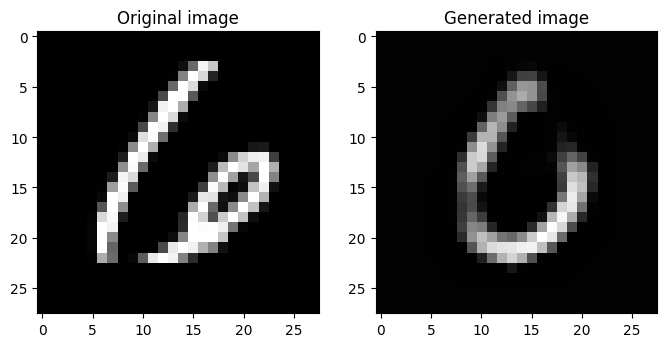

In [31]:
id = torch.randint(0, len(Xn_test),(1,1))

fig, axes = plt.subplots(1,2, figsize=(8,10) )

axes[0].imshow(Xn_test[id].view(28,28).cpu(), cmap='gray')
axes[0].set_title('Original image')

axes[1].imshow(vae.reproduce(Xn_test[id].view(1,1,28,28)).cpu().view(28,28), cmap='gray')
axes[1].set_title('Generated image')

plt.show()

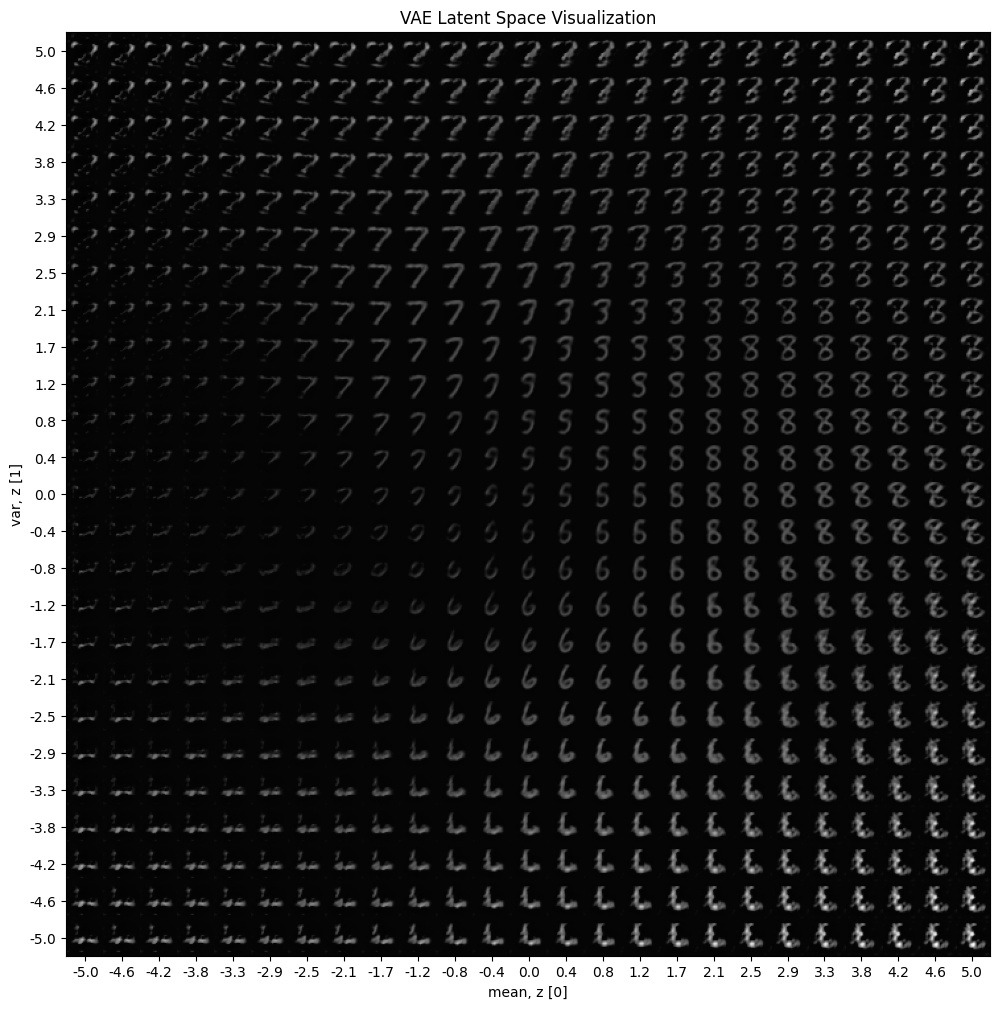

In [33]:
def plot_latent_space(model, scale=5.0, n=25, digit_size=28, figsize=12):
    # display a n*n 2D manifold of digits
    figure = np.zeros((digit_size * n, digit_size * n))

    # construct a grid 
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = torch.tensor([[xi, yi, 0, 0, 0]], dtype=torch.float, device=device)
            x_decoded = model.decode(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size : (i + 1) * digit_size, j * digit_size : (j + 1) * digit_size,] = digit.cpu()

    plt.figure(figsize=(figsize, figsize))
    plt.title('VAE Latent Space Visualization')
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("mean, z [0]")
    plt.ylabel("var, z [1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(vae)

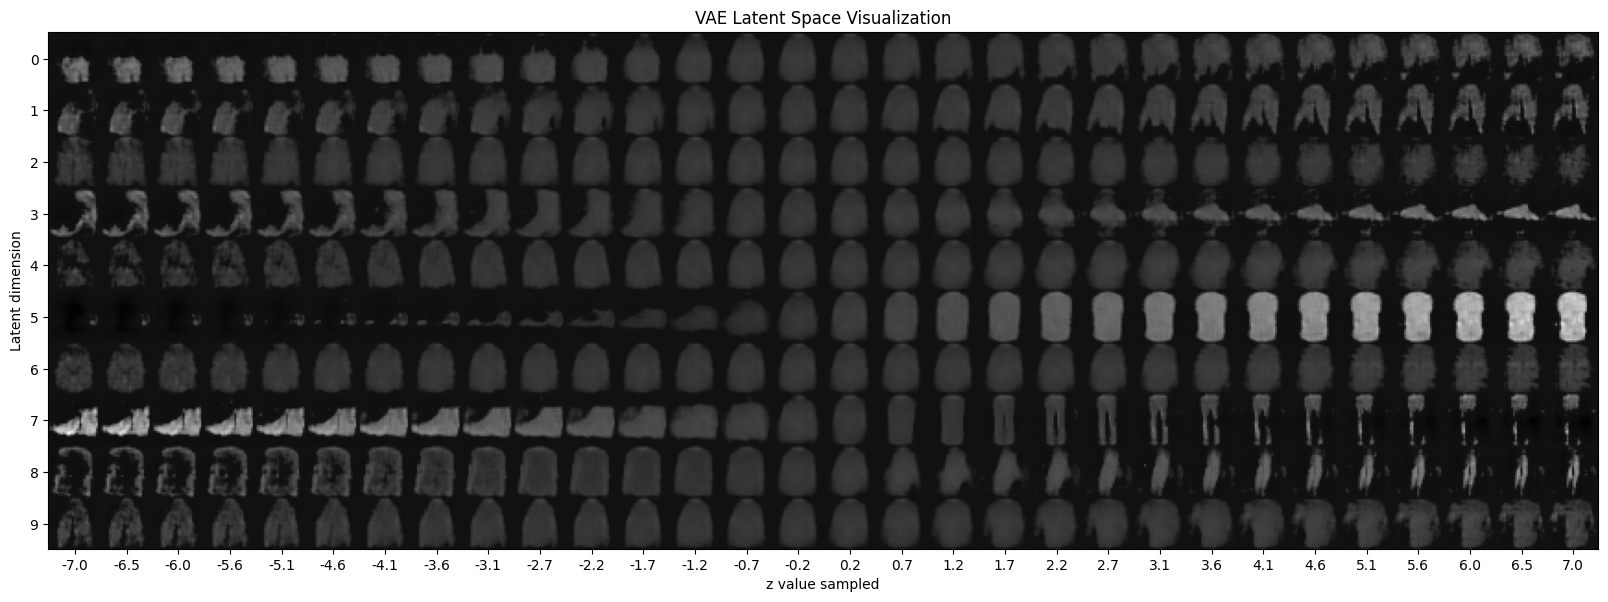

In [32]:
scale= 7.0
n= 30
digit_size= 28 
figsize= 20
latent_dim = 10

figure = np.zeros((latent_dim*digit_size, digit_size * n))
grid_x = np.linspace(-scale, scale, n)

for i in range(latent_dim):
   for j, xi in enumerate(grid_x):
            z_sample = torch.tensor([[ (i == 0)*xi, (i == 1)*xi, (i == 2)*xi, (i == 3)*xi, (i == 4)*xi,( i == 5)*xi, (i == 6)*xi, (i == 7)*xi, (i == 8)*xi, (i == 9)*xi,
                                      #(i == 10)*xi, (i == 11)*xi, (i == 12)*xi, (i == 13)*xi, (i == 14)*xi,( i == 15)*xi, (i == 16)*xi, (i == 17)*xi, (i == 18)*xi, (i == 19)*xi]],
                                        ]],dtype=torch.float, device=device)
            x_decoded = vae.decode(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size : (i + 1) * digit_size, j * digit_size : (j + 1) * digit_size,] = digit.cpu()

plt.figure(figsize=(figsize, figsize))
plt.title('VAE Latent Space Visualization')
start_range = digit_size // 2
end_range = n * digit_size + start_range
pixel_range_x = np.arange(start_range, end_range, digit_size)
pixel_range_y = np.arange(start_range, latent_dim* digit_size + start_range, digit_size)
sample_range_x = np.round(grid_x, 1)
sample_range_y = range(latent_dim)
plt.xticks(pixel_range_x, sample_range_x)
plt.yticks(pixel_range_y, sample_range_y)
plt.xlabel("z value sampled")
plt.ylabel("Latent dimension")
plt.imshow(figure, cmap="gray")
plt.show()       

In [33]:
from sklearn import svm
from sklearn import metrics

svm = svm.SVC()

Z = vae.encode(Xn_test.view(len(Xn_test),1,28,28)).cpu()

svm.fit(Z,Y)
y_pred = svm.predict(Z)

print('The accuracy in disentagling the classes is', metrics.accuracy_score(Y,y_pred))

print(metrics.classification_report(Y,y_pred))
print(metrics.confusion_matrix(Y,y_pred))

The accuracy in disentagling the classes is 0.7896
              precision    recall  f1-score   support

           0       0.73      0.80      0.76      1000
           1       0.98      0.94      0.96      1000
           2       0.65      0.60      0.63      1000
           3       0.79      0.85      0.82      1000
           4       0.65      0.69      0.67      1000
           5       0.90      0.83      0.86      1000
           6       0.51      0.43      0.47      1000
           7       0.84      0.86      0.85      1000
           8       0.93      0.95      0.94      1000
           9       0.89      0.92      0.91      1000

    accuracy                           0.79     10000
   macro avg       0.79      0.79      0.79     10000
weighted avg       0.79      0.79      0.79     10000

[[802   3  23  91   4   1  61   0  15   0]
 [  8 941   8  34   0   1   8   0   0   0]
 [ 11   0 603   8 196   0 168   0  14   0]
 [ 38  15   3 855  38   0  48   0   3   0]
 [  4   1 134  48 